In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import emcee
import corner 
from scipy.optimize import minimize
from IPython.display import display, Math

mpl.rc("font", family = "Times New Roman")


def aesthetic(ax):
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    for tick in ax.get_xticklabels():
        tick.set_fontname('Times New Roman')
    for tick in ax.get_yticklabels():
        tick.set_fontname('Times New Roman')
    ax.margins(x=0.15,y=0.15,tight=True)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(direction='in',axis='both',which='minor',length=6,width=2,labelsize=25)
    ax.tick_params(direction='in',axis='both',which='major',length=12,width=2,labelsize=25)
    ax.minorticks_on()

In [2]:
df = pd.read_csv('AT2019dsg_data.csv', dtype = {'nu':float, 'F':float})
df2 = pd.read_csv('AT2019dsg_data_stein_et_al.csv', dtype = {'nu':float, 'F':float})

df = df.drop([35,36,47])
df2 = df2.drop([5,6,7, 16,17,18])

df_55 = df[df.t==55]
df_60 = df[df.t==60]
df_82 = df[df.t==82]
df_161 = df[df.t==161]
df_300 = df[df.t==300]
df_52 = df2[df2.t==52]
df_80 = df2[df2.t==80]
df_130 = df2[df2.t==130]
df_188 = df2[df2.t==188]

## Free p

In [3]:
chains = []
p_vals = []
Fnu_vals = []
nua_vals = []
p_error = []
Fnu_error = []
nua_error = []
Fp = []
Fp_error = []
nup = []
nup_error = []
def loglik(theta, nu, F, F_error):
    ''' Log Likelihood function'''
    p, F_nu, nu_a = theta
    model = SED(nu, p, F_nu, nu_a )
    sigma2 = F_error**2 #+ model**2*np.exp(2 * log_f)
    
    chi2 = np.sum((F - model)**2/sigma2)
    ll = -0.5*chi2
    #ll = np.sum(np.log(1/np.sqrt(2*np.pi * (sigma2))) - 0.5*((F - model)**2/(sigma2)))
    return ll

def lnprior(theta):
    ''' Priors: '''
    p, F_nu, nu_a = theta
    if 2< p < 4 and 1e-7 < F_nu < 5e-4 and 5e7 < nu_a < 5e10: #and s2 > 0.5:
        return 0.0
    else:
        return -np.inf    
    
    
def lnprob(theta, nu, F, F_error):
    '''Keep or throw away step likelihood and priors'''
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + loglik(theta, nu, F, F_error)

def SED(nu, p, F_nu, nu_a):
    b2 = 5/2
    b3 = (1-p)/2
    #s2 = 1.25-0.18*p
    #s2 = 1.117
    s2 = 1.5
    s4 = 3.63*p-1.6
    nu_m = 0.1e9
    term1 = (nu/nu_m)**2*np.exp(-s4*(nu/nu_m)**(2/3))
    term2 = (nu/nu_m)**(5/2)
    term3 = (1+(nu/nu_a)**(s2*(b2-b3)))**(-1/s2)
    return F_nu*(term1+term2)*term3

def do_emcee(df, day, theta_init):
    
    nu = 1e9*df.nu
    F = df.F
    F_error = df.F_error
    
    ### Fill in initial guesses 
    theta_init = np.array(theta_init)
    # number of parameters
    ndim = len(theta_init)

    pos = np.array([np.array(theta_init) + [0.1*theta_init[0],0.1*theta_init[1],
                                            0.1*theta_init[2]]*np.random.randn(ndim) for i in range(32)])
    #soln.x + 1e-4 * np.random.randn(32, 4)
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(nu, F, F_error))
    pos, prob, state = sampler.run_mcmc(pos, 2000, progress=True);
    
    #Plot chains
    fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = ["p", "F_nu", "nu_a"]
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");
    fig.savefig('final_plots/day_'+str(day)+'_chains.jpg')
    
    #Corner Plot
    flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
    
    chains.append(flat_samples)
    
    fig = corner.corner(flat_samples, labels=labels);
    fig.savefig('final_plots/day_'+str(day)+'_corner.jpg')
    
    #Print best fit parameters
    print('Best fit values for day: ', day)
    p_value = []
    for i, lst, lst_errs in zip(range(ndim), [p_vals, Fnu_vals, nua_vals], [p_error, Fnu_error, nua_error]):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        vals = [mcmc[1],(q[0]+q[1])/2]
        lst.append(vals[0])
        lst_errs.append(vals[1])
        
        txt = "\mathrm{{{3}}} = {0:.2e}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        p_value.append(mcmc[1])
        display(Math(txt))
        
    
    nu_plot = np.arange(1e8,1e11,1e8)
    fig = plt.figure(figsize = (8,8))
    ax = plt.subplot(111)
    temp1 = []
    temp2 = []
    for i in range(len(flat_samples[1000:,0])):
        ax.plot(nu_plot, SED(nu_plot, flat_samples[1000:,0][i], flat_samples[1000:,1][i],
                             flat_samples[1000:,2][i]), '-k', lw = 0.5, alpha = 0.01)
    
        temp1.append(np.average(max(SED(nu_plot, flat_samples[1000:,0][i],
                                       flat_samples[1000:,1][i],flat_samples[1000:,2][i]))))
        idx = np.argmax(SED(nu_plot, flat_samples[1000:,0][i],
                                       flat_samples[1000:,1][i],flat_samples[1000:,2][i]))
        temp2.append(nu_plot[idx])
    
    Fp.append(np.average(temp1))
    Fp_error.append(np.std(temp1))
    
    nup.append(np.average(temp2))
    nup_error.append(np.std(temp2))
               
    ax.plot(nu,F, 'o', markeredgecolor = 'black', markeredgewidth=3, markersize= 15, color = 'red')
    ax.text(1.25e9,1.5,s='Day '+ day, fontsize = 20)
    ax.text(1.25e9,0.8,s='P = ' + str(np.round(p_value[0], 2)), fontsize = 20)
    ax.set_ylim(0.02,2.5)
    ax.set_xlim(1e9,5e10)
    ax.set_yscale('log')
    ax.set_xscale('log')
    aesthetic(ax)
    fig.savefig('final_plots/day_'+str(day)+'_SED_fit.jpg')

100%|███████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 67.87it/s]


Best fit values for day:  52


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

100%|███████████████████████████████████████████████████████| 2000/2000 [00:30<00:00, 65.00it/s]


Best fit values for day:  55


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

100%|███████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.15it/s]


Best fit values for day:  60


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

100%|███████████████████████████████████████████████████████| 2000/2000 [00:30<00:00, 64.73it/s]


Best fit values for day:  80


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

100%|███████████████████████████████████████████████████████| 2000/2000 [00:34<00:00, 57.22it/s]


Best fit values for day:  82


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

100%|███████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 64.24it/s]


Best fit values for day:  130


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

100%|███████████████████████████████████████████████████████| 2000/2000 [00:35<00:00, 56.92it/s]


Best fit values for day:  161


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

/tmp/ipykernel_1864375/2669300620.py:111: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (8,8))
100%|███████████████████████████████████████████████████████| 2000/2000 [00:34<00:00, 57.61it/s]


Best fit values for day:  188


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

100%|███████████████████████████████████████████████████████| 2000/2000 [00:34<00:00, 57.71it/s]


Best fit values for day:  300


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

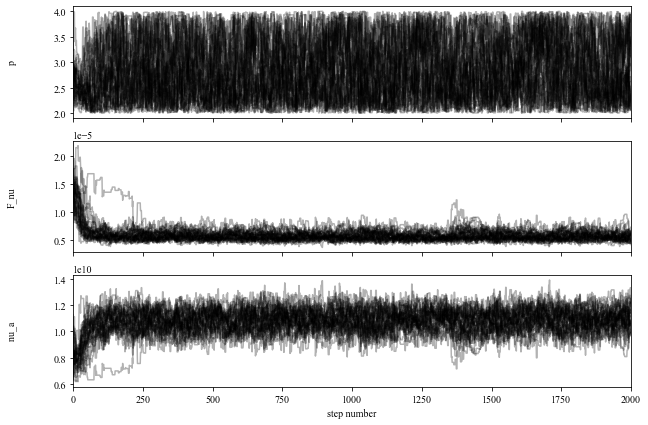

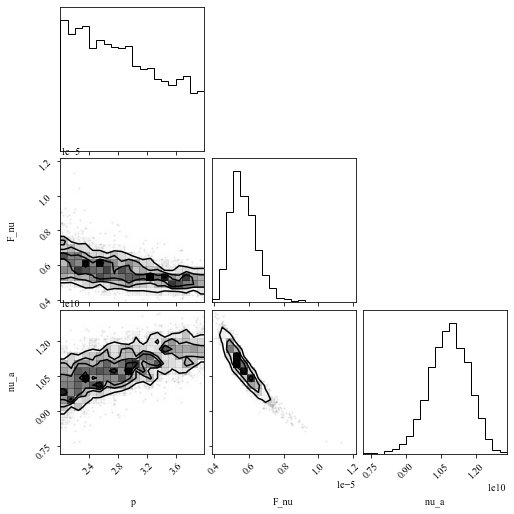

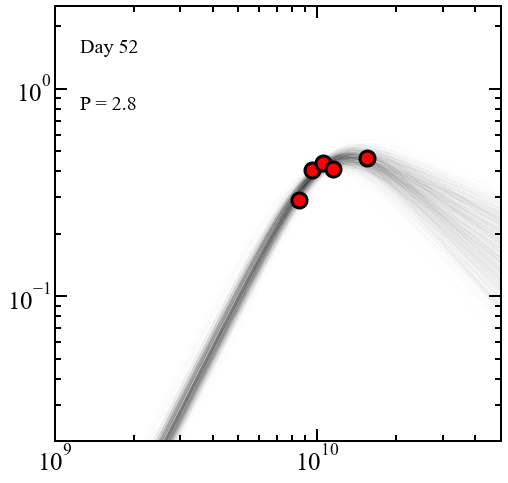

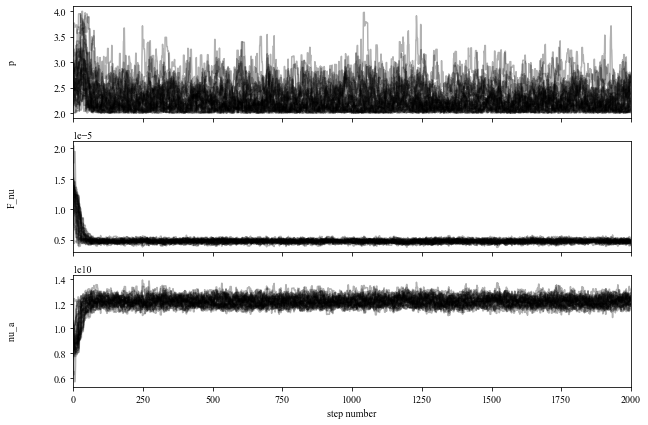

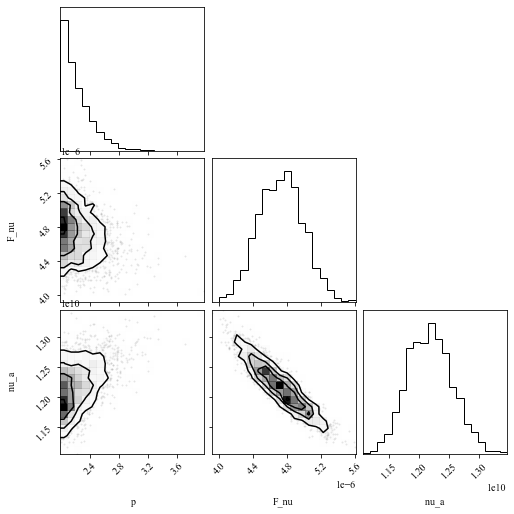

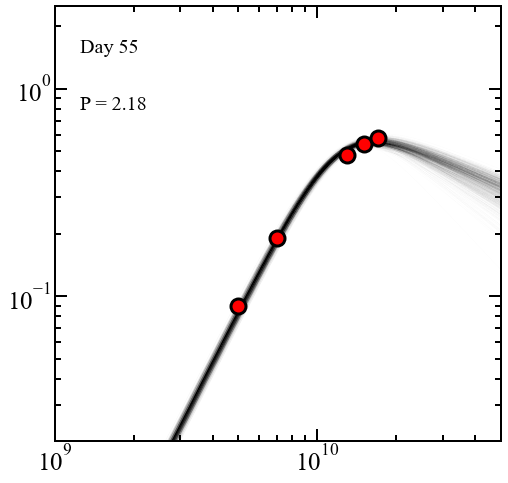

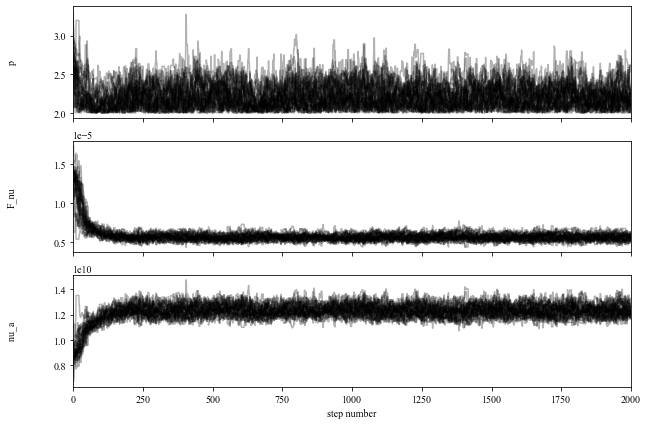

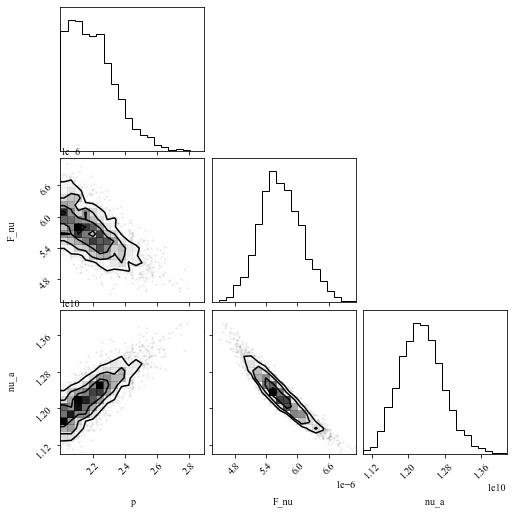

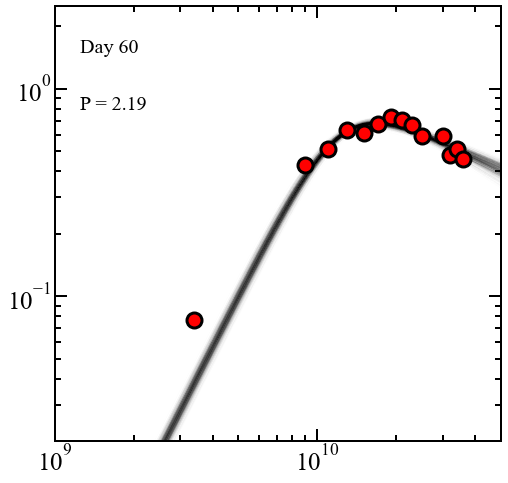

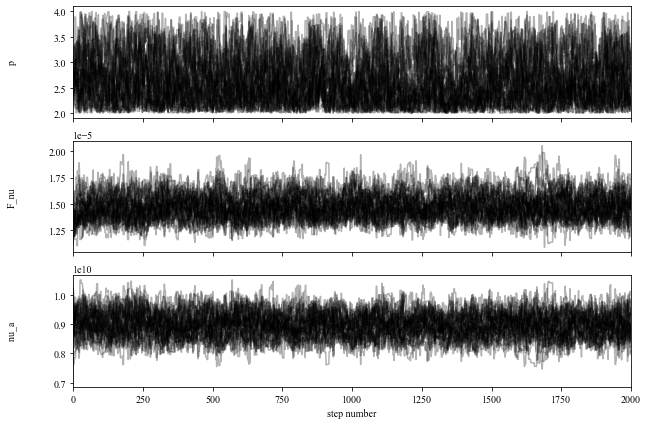

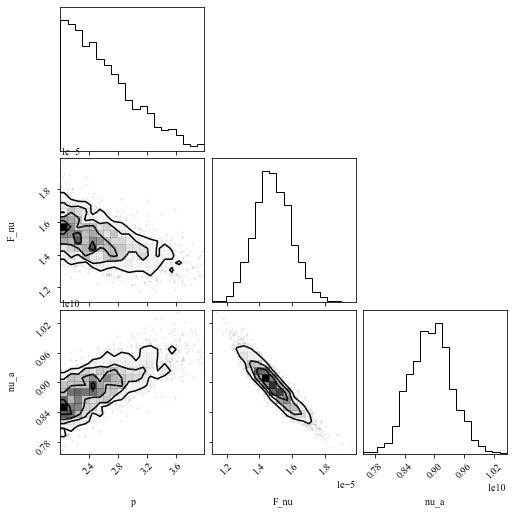

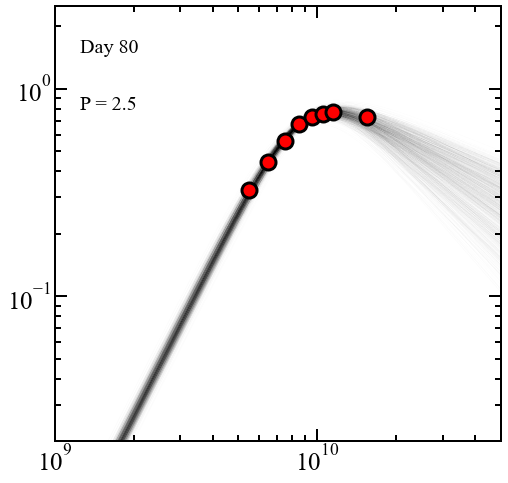

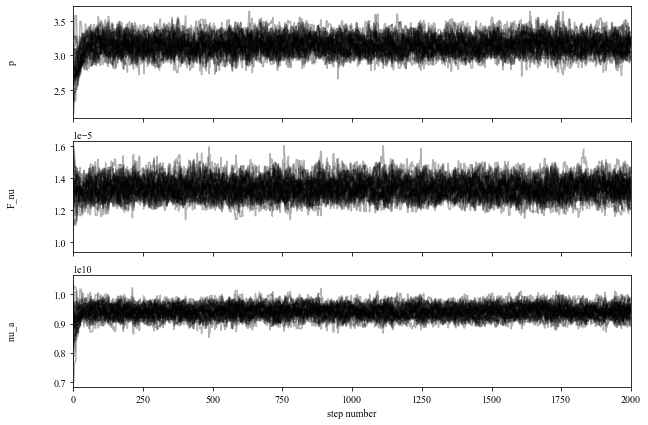

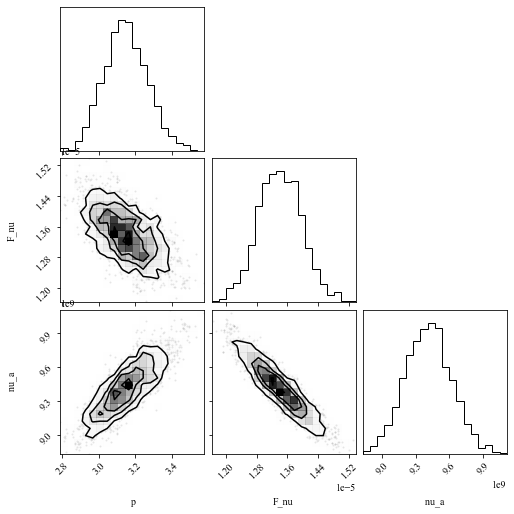

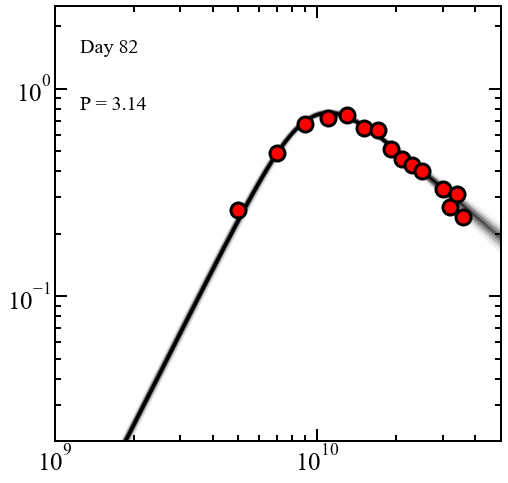

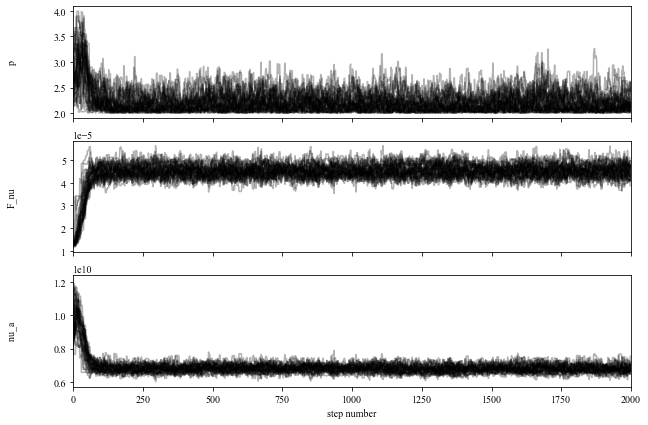

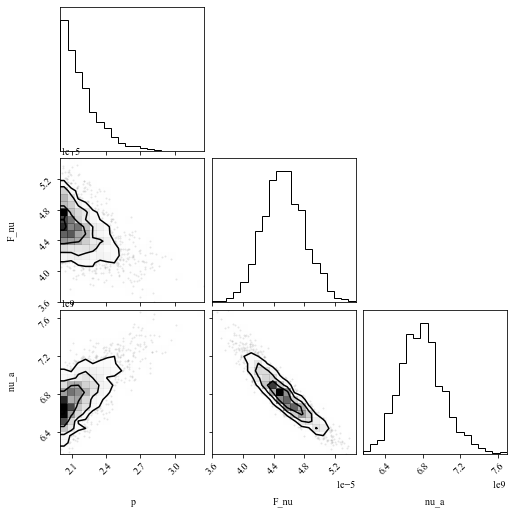

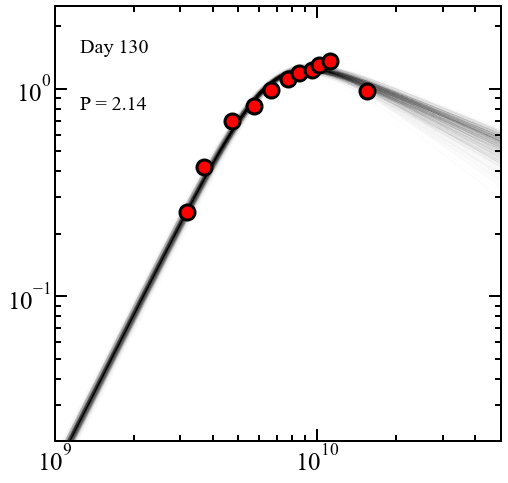

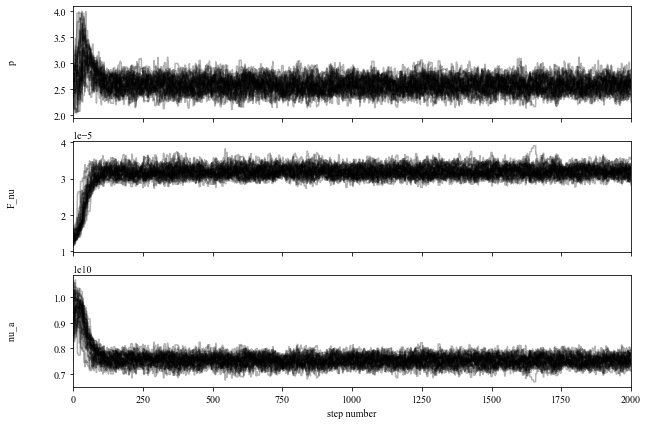

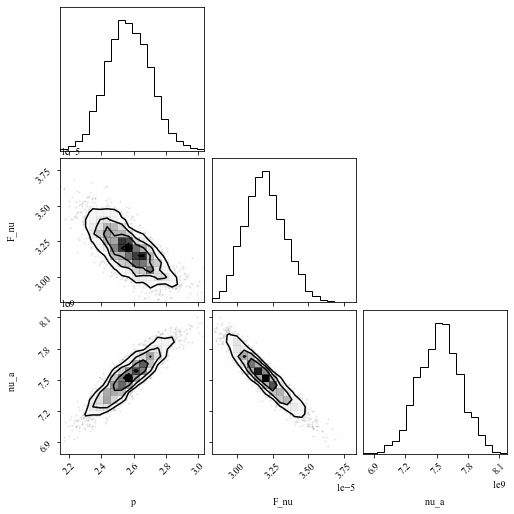

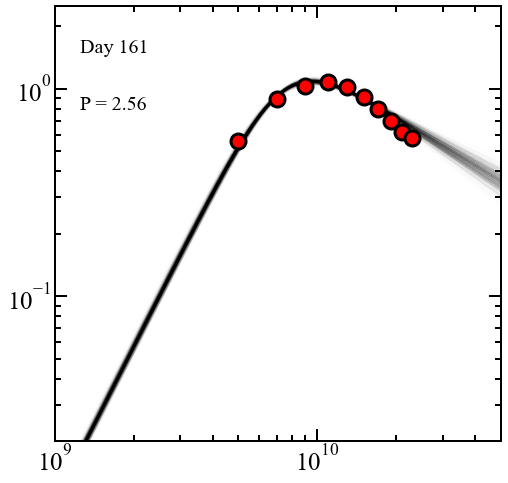

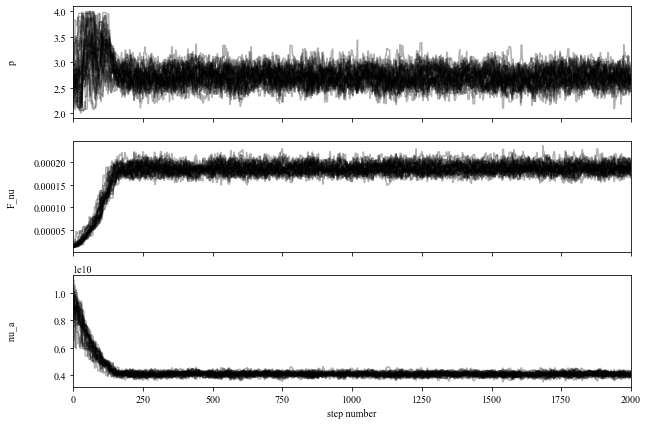

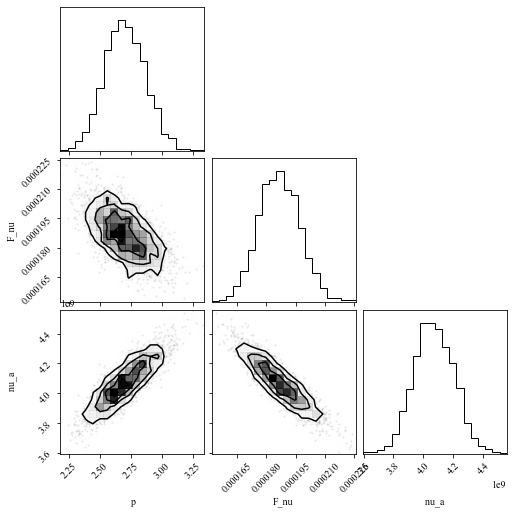

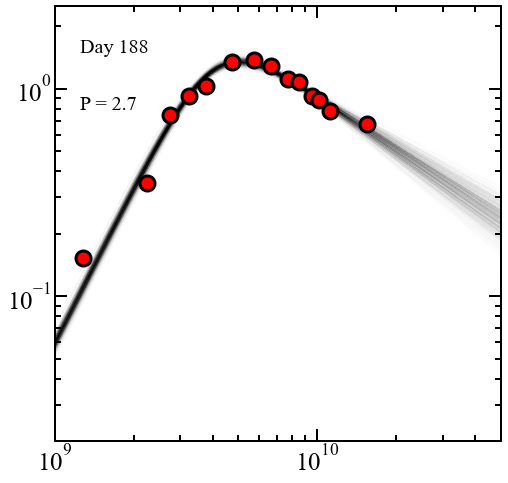

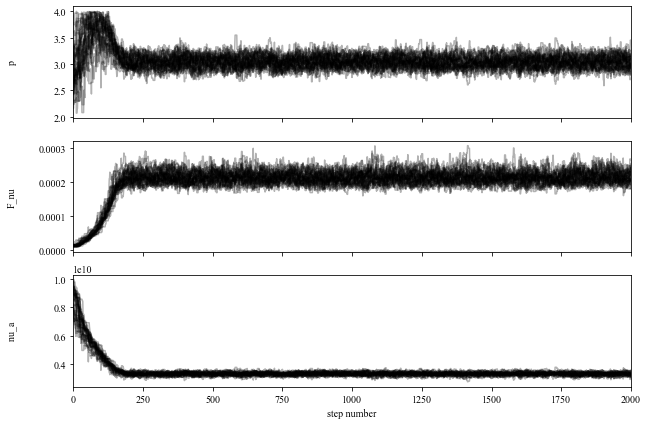

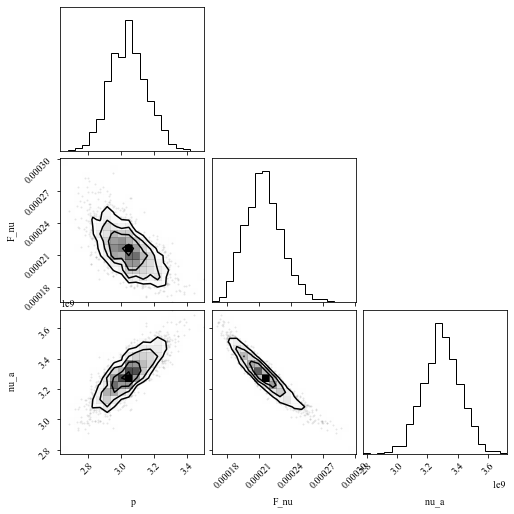

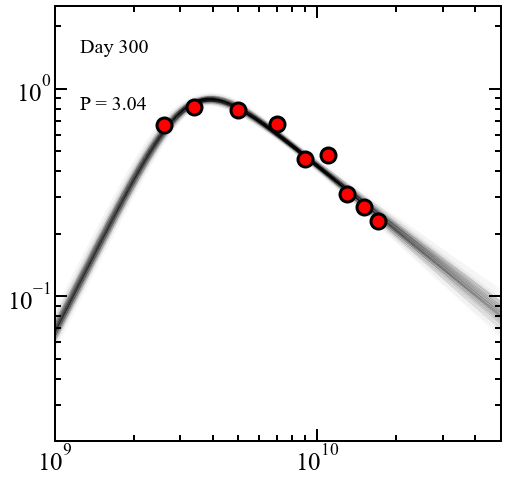

In [4]:
do_emcee(df_52, '52', [2.7, 1.33e-5, 8.92e9])
do_emcee(df_55, '55', [2.7, 1.33e-5, 8.92e9])
do_emcee(df_60, '60',  [2.7, 1.33e-5, 8.92e9])
do_emcee(df_80, '80', [2.7, 1.33e-5, 8.92e9])
do_emcee(df_82, '82', [2.7, 1.33e-5, 8.92e9])
do_emcee(df_130, '130', [2.7, 1.33e-5, 8.92e9])
do_emcee(df_161, '161', [2.7, 1.33e-5, 8.92e9])
do_emcee(df_188, '188', [2.7, 1.33e-5, 8.92e9])
do_emcee(df_300, '300', [2.7, 1.33e-5, 8.92e9])

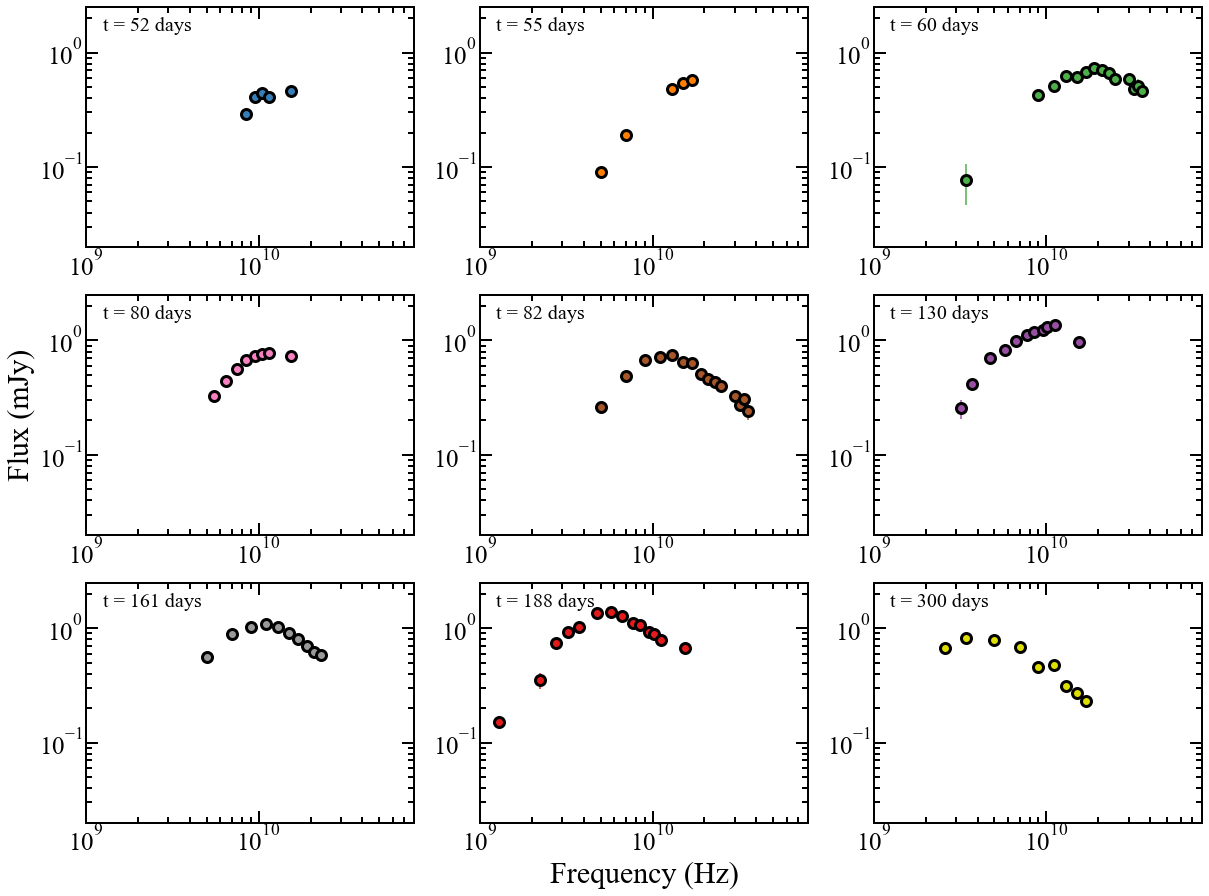

In [17]:
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
fig = plt.figure(figsize = (20,15))
ax1 = plt.subplot(331)
ax2 = plt.subplot(332)
ax3 = plt.subplot(333)
ax4 = plt.subplot(334)
ax5 = plt.subplot(335)
ax6 = plt.subplot(336)
ax7 = plt.subplot(337)
ax8 = plt.subplot(338)
ax9 = plt.subplot(339)
nu_plot = np.arange(1e8,1e11,1e8)
for time,df,ax,i in zip([52,55,60,80,82,130,161,188,300],
                   [df_52,df_55,df_60,df_80,df_82,df_130,df_161,df_188,df_300], 
                     [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9], 
                     [0,1,2,3,4,5,6,7,8]):
    if i == 3:
        ax.set_ylabel('Flux (mJy)', fontsize = 30)
    if i == 7:
        ax.set_xlabel('Frequency (Hz)', fontsize = 30)
    
    #ax.vlines(x = 9272571942, ymin = 0, ymax = 3, color = 'black')
    ax.errorbar(x=1e9*df.nu,y=df.F, yerr = df.F_error, fmt = 'o', markeredgecolor = 'black', markeredgewidth=3, markersize= 10, color = colors[i])
    ax.set_ylim(0.02,2.5)
    ax.set_xlim(1e9,8e10)
    ax.set_yscale('log')
    ax.set_xscale('log')
    aesthetic(ax)
    ax.text(x=0.05,y=0.9,s='t = '+str(time)+' days',fontsize = 20, transform=ax.transAxes)
fig.savefig('final_plots/SED_ALL_data.jpg')

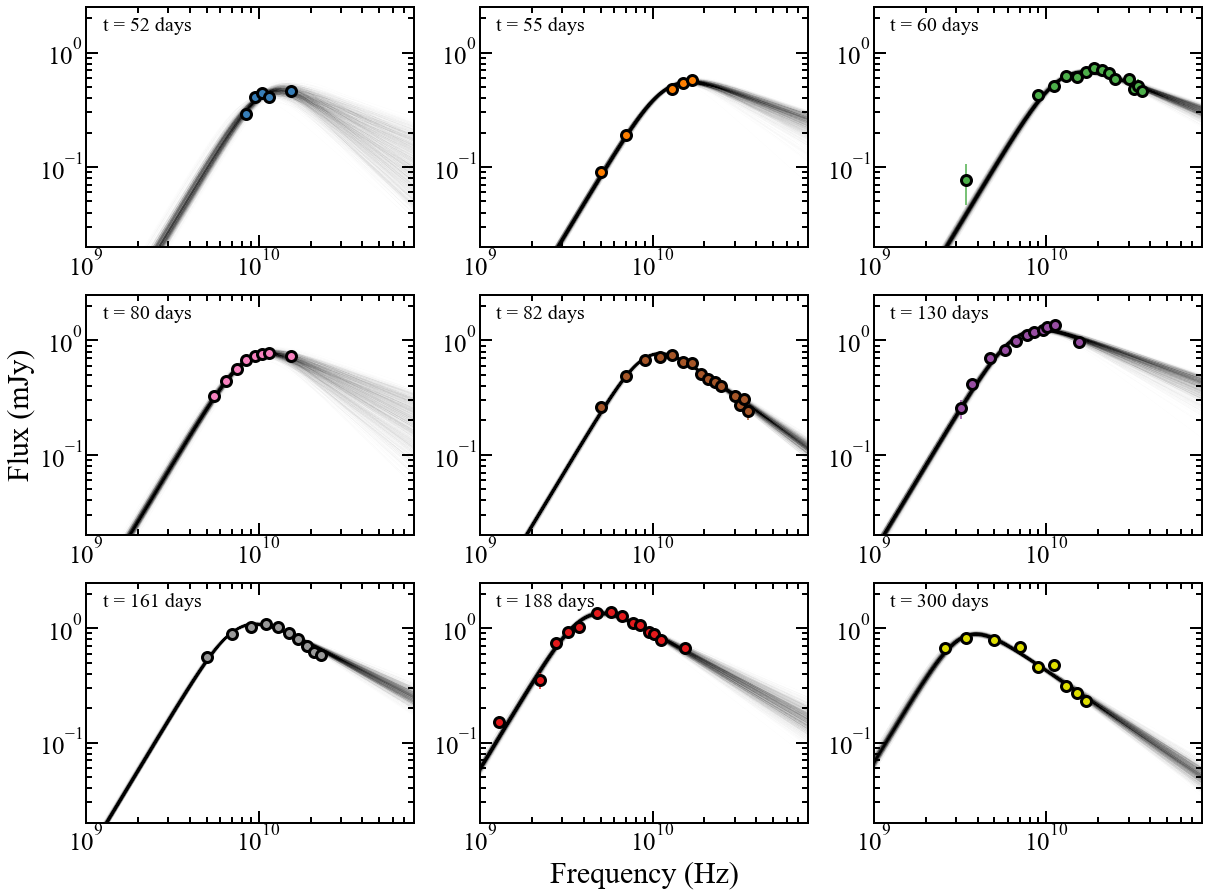

In [18]:
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
fig = plt.figure(figsize = (20,15))
ax1 = plt.subplot(331)
ax2 = plt.subplot(332)
ax3 = plt.subplot(333)
ax4 = plt.subplot(334)
ax5 = plt.subplot(335)
ax6 = plt.subplot(336)
ax7 = plt.subplot(337)
ax8 = plt.subplot(338)
ax9 = plt.subplot(339)
nu_plot = np.arange(1e8,1e11,1e8)
for time,df,ax,i in zip([52,55,60,80,82,130,161,188,300],
                   [df_52,df_55,df_60,df_80,df_82,df_130,df_161,df_188,df_300], 
                     [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9], 
                     [0,1,2,3,4,5,6,7,8]):
    
    for k in range(len(chains[i][1000:,0])):
        ax.plot(nu_plot, SED(nu_plot, chains[i][1000:,0][k], chains[i][1000:,1][k],
                         chains[i][1000:,2][k]), '-k', lw = 0.5, alpha = 0.01)
        #ax.vlines(x = chains[i][1000:,2][k], ymin = 0, ymax = 3)
    if i == 3:
        ax.set_ylabel('Flux (mJy)', fontsize = 30)
    if i == 7:
        ax.set_xlabel('Frequency (Hz)', fontsize = 30)
    
    #ax.vlines(x = 9272571942, ymin = 0, ymax = 3, color = 'black')
    ax.errorbar(x=1e9*df.nu,y=df.F, yerr = df.F_error, fmt = 'o', markeredgecolor = 'black', markeredgewidth=3, markersize= 10, color = colors[i])
    ax.set_ylim(0.02,2.5)
    ax.set_xlim(1e9,8e10)
    ax.set_yscale('log')
    ax.set_xscale('log')
    aesthetic(ax)
    ax.text(x=0.05,y=0.9,s='t = '+str(time)+' days',fontsize = 20, transform=ax.transAxes)
fig.savefig('final_plots/SED_ALL.jpg')

In [19]:
p_weights = np.array([1/(sigma**2) for sigma in p_error])
print(np.round(np.sum(p_vals*p_weights)/np.sum(p_weights),3),'+/-',np.round(np.sqrt(1/np.sum(p_weights)),3))

2.661 +/- 0.052


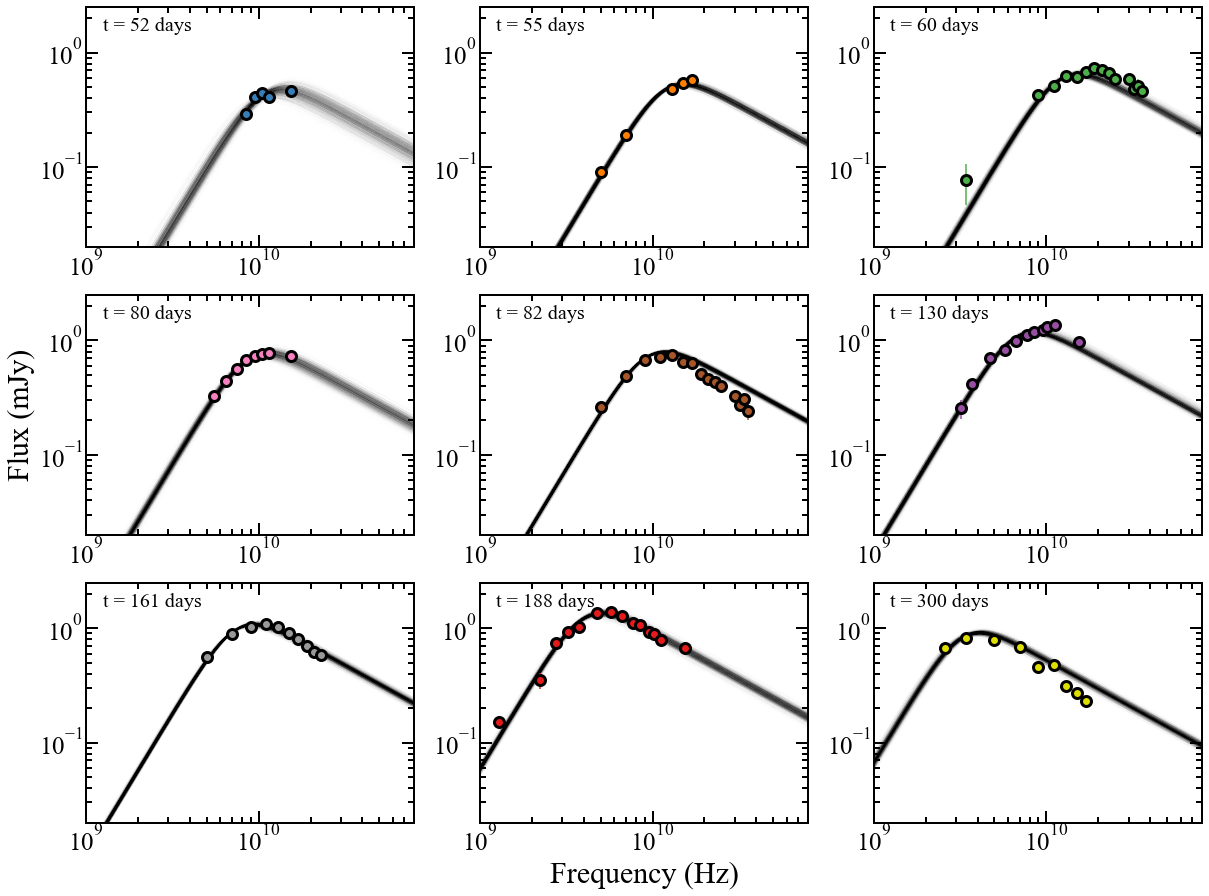

In [20]:
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
fig = plt.figure(figsize = (20,15))
ax1 = plt.subplot(331)
ax2 = plt.subplot(332)
ax3 = plt.subplot(333)
ax4 = plt.subplot(334)
ax5 = plt.subplot(335)
ax6 = plt.subplot(336)
ax7 = plt.subplot(337)
ax8 = plt.subplot(338)
ax9 = plt.subplot(339)
nu_plot = np.arange(1e8,1e11,1e8)
for time,df,ax,i in zip([52,55,60,80,82,130,161,188,300],
                   [df_52,df_55,df_60,df_80,df_82,df_130,df_161,df_188,df_300], 
                     [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9], 
                     [0,1,2,3,4,5,6,7,8]):
    
    for k in range(len(chains[i][1000:,0])):
        ax.plot(nu_plot, SED(nu_plot, 2.7, chains[i][1000:,1][k],
                         chains[i][1000:,2][k]), '-k', lw = 0.5, alpha = 0.01)
        #ax.vlines(x = chains[i][1000:,2][k], ymin = 0, ymax = 3)
    if i == 3:
        ax.set_ylabel('Flux (mJy)', fontsize = 30)
    if i == 7:
        ax.set_xlabel('Frequency (Hz)', fontsize = 30)
    
    #ax.vlines(x = 9272571942, ymin = 0, ymax = 3, color = 'black')
    ax.errorbar(x=1e9*df.nu,y=df.F, yerr = df.F_error, fmt = 'o', markeredgecolor = 'black', markeredgewidth=3, markersize= 10, color = colors[i])
    ax.set_ylim(0.02,2.5)
    ax.set_xlim(1e9,8e10)
    ax.set_yscale('log')
    ax.set_xscale('log')
    aesthetic(ax)
    ax.text(x=0.05,y=0.9,s='t = '+str(time)+' days',fontsize = 20, transform=ax.transAxes)
fig.savefig('final_plots/SED_ALL.jpg')

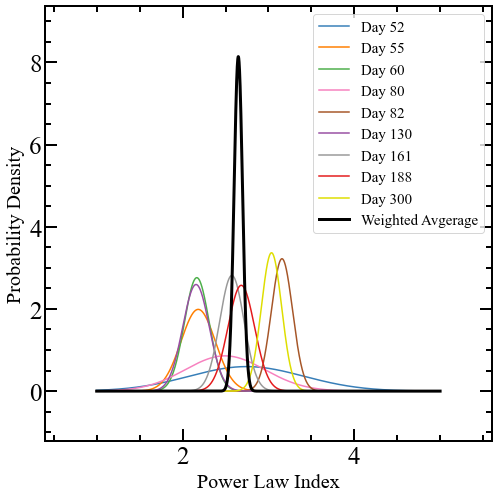

In [9]:
from scipy.stats import norm
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
fig = plt.figure(figsize = (8,8))
ax = plt.subplot(111)
x = np.arange(1,5, 0.001)
for i, c,l in zip(range(9), colors, ['Day 52','Day 55','Day 60','Day 80','Day 82','Day 130','Day 161','Day 188','Day 300']):
    ax.plot(x, norm.pdf(x, p_vals[i], p_error[i]), color = c, label = l)
    
ax.plot(x, norm.pdf(x, 2.649, 0.049), color = 'k', lw = 3,  label = "Weighted Avgerage")
ax.set_ylabel('Probability Density', fontsize = 20)
ax.set_xlabel('Power Law Index', fontsize = 20)
ax.legend(fontsize = 15)
aesthetic(ax)
fig.savefig('final_plots/p_fits_distribution.jpg')

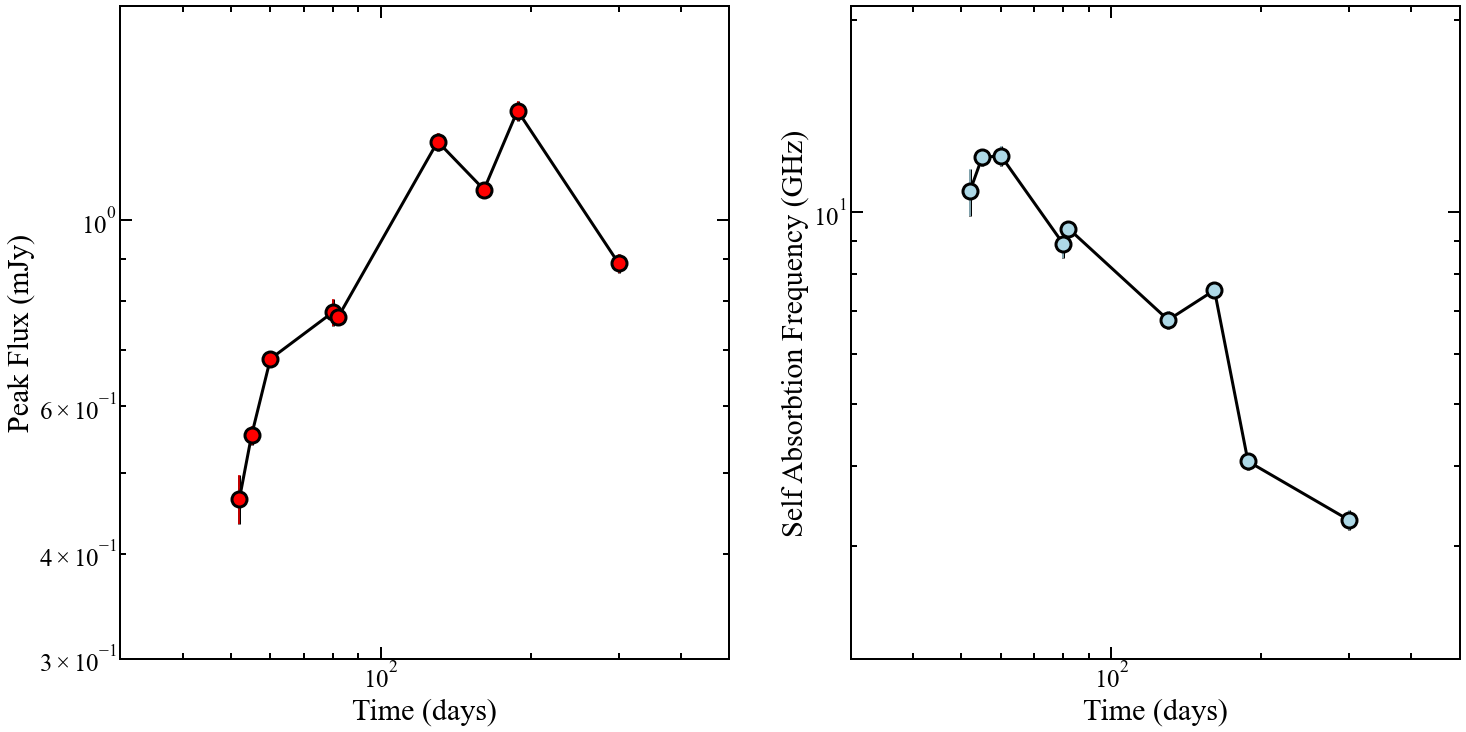

In [10]:
fig = plt.figure(figsize = (24,12))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
time = [52,55,60,80,82,130,161,188,300]

ax1.errorbar(x=time,y=Fp, yerr = Fp_error, fmt = '-', linewidth=3, markersize= 1, color = 'k')
ax1.errorbar(x=time,y=Fp, yerr = Fp_error, fmt = 'o', markeredgecolor = 'black', markeredgewidth=3, markersize= 15, color = 'red')
ax1.set_yscale('log')
ax1.set_xscale('log')
aesthetic(ax1)

nua_vals = np.array(nua_vals) 
nua_error = np.array(nua_error) 

ax2.errorbar(x=time,y=nua_vals*10**(-9), yerr = nua_error*10**(-9), fmt = '-', linewidth=3, markersize= 1, color = 'k')
ax2.errorbar(x=time,y=nua_vals*10**(-9), yerr = nua_error*10**(-9), fmt = 'o', markeredgecolor = 'black', markeredgewidth=3, markersize= 15, color = 'lightblue')


#ax2.errorbar(x=time,y=nup*10**(-9), yerr = nup_error*10**(-9), fmt = '-', linewidth=3, markersize= 1, color = 'k')
#ax2.errorbar(x=time,y=nup*10**(-9), yerr = nup_error*10**(-9), fmt = 'o', markeredgecolor = 'black', markeredgewidth=3, markersize= 15, color = 'red')
ax2.set_yscale('log')
ax2.set_xscale('log')
aesthetic(ax2)

ax1.set_xlim(3e1,5e2)
ax2.set_xlim(3e1,5e2)

ax1.set_ylim(0.3,1.8)
ax2.set_ylim(2,21)



ax1.set_ylabel('Peak Flux (mJy)', fontsize = 30)
ax2.set_ylabel('Self Absorbtion Frequency (GHz)', fontsize = 30)
ax1.set_xlabel('Time (days)', fontsize = 30)
ax2.set_xlabel('Time (days)', fontsize = 30)
fig.savefig('final_plots/Fp_and_nu_overtime.jpg')

# Compute R, E, B, N

In [5]:
fa = 1
fv = 0.36
epe = 0.1
epb = 0.02
xi = 1+epe**(-1)
ep = (11/6)*(epe/epb)
gm = 2
d = 7.097e26 # 230 Mpc in cgs
z = 0.051

In [6]:
import numpy as np
from eq_scripts import eq_radius,eq_energy,eq_Bfield,eq_Ne

In [7]:
tempR = eq_radius(2.7,0.47,230,10**10.2)
print('Log(R): ',np.log10(eq_radius(2.7,0.47,230,10**10.2)))
print('Log(E): ',np.log10(eq_energy(2.7,0.47,230,10**10.2)))
print('Log(B): ',np.log10(eq_Bfield(2.7,0.47,230,tempR,10**10.2)))
print('Log(N): ',np.log10(eq_Ne(2.7,0.47,230,tempR, 10**10.2)))

Log(R):  15.959339939129432
Log(E):  47.59887325991575
Log(B):  0.319814388919836
Log(N):  51.52910824037471


In [8]:
R_list = []
E_list = []
B_list = []
N_list = []

for i in range(9):
    R_list.append(eq_radius(2.7,Fp[i],230,nup[i]))
    E_list.append(eq_energy(2.7,Fp[i],230,nup[i]))
    B_list.append(eq_Bfield(2.7,Fp[i],230,R_list[i],nup[i]))
    N_list.append(eq_Ne(2.7,Fp[i],230,R_list[i],nup[i]))

In [12]:
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

time = [52,55,60,80,82,130,161,188,300]
Rm, Rb = np.polyfit(np.log10(time), np.log10(R_list), 1)
Em, Eb = np.polyfit(np.log10(time), np.log10(E_list), 1)
Bm, Bb = np.polyfit(np.log10(time), np.log10(B_list), 1)
Nm, Nb = np.polyfit(np.log10(time), np.log10(N_list), 1)

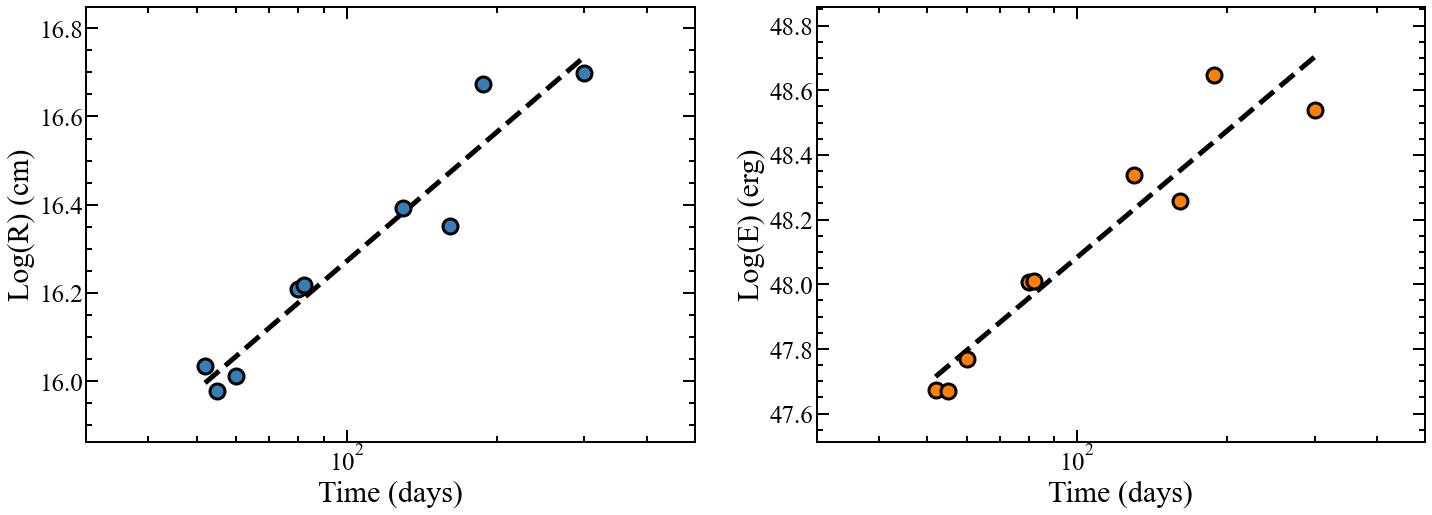

In [13]:
fig = plt.figure(figsize = (24,8))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
time = [52,55,60,80,82,130,161,188,300]

ax1.plot(time, Rm*np.log10(np.array(time))+Rb, 'k--', lw = 5)
ax1.plot(time,np.log10(R_list), 'o', markeredgecolor = 'black', markeredgewidth=3, markersize= 15, color = colors[0])
ax2.plot(time, Em*np.log10(np.array(time))+Eb, 'k--', lw = 5)
ax2.plot(time,np.log10(E_list), 'o', markeredgecolor = 'black', markeredgewidth=3, markersize= 15, color = colors[1])
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_ylabel('Log(R) (cm)', fontsize = 30)
ax1.set_xlabel('Time (days)', fontsize = 30)
ax2.set_ylabel('Log(E) (erg)', fontsize = 30)
ax2.set_xlabel('Time (days)', fontsize = 30)
ax1.set_xlim(3e1,5e2)
ax2.set_xlim(3e1,5e2)
aesthetic(ax1)
aesthetic(ax2)
fig.savefig('final_plots/R_and_E_overtime.jpg')

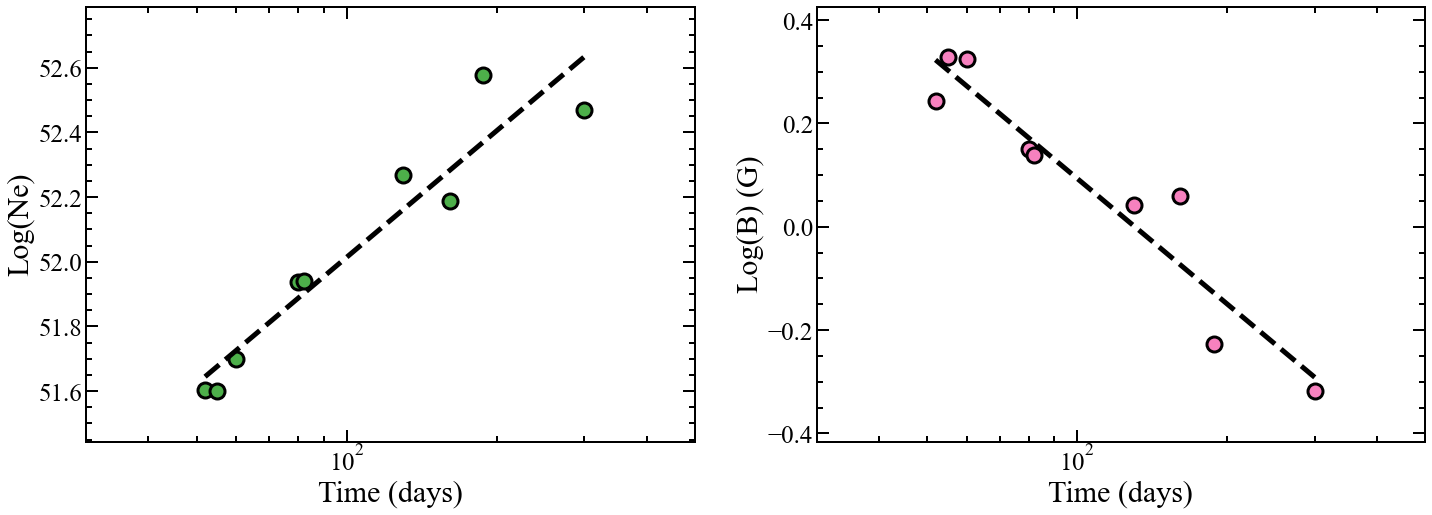

In [14]:
fig = plt.figure(figsize = (24,8))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
time = [52,55,60,80,82,130,161,188,300]

ax1.plot(time,np.log10(N_list), 'o', markeredgecolor = 'black', markeredgewidth=3, markersize= 15, color = colors[2])
ax1.plot(time, Nm*np.log10(np.array(time))+Nb, 'k--', lw = 5)
ax2.plot(time,np.log10(B_list), 'o', markeredgecolor = 'black', markeredgewidth=3, markersize= 15, color = colors[3])
ax2.plot(time, Bm*np.log10(np.array(time))+Bb, 'k--', lw = 5)
#ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_ylabel('Log(Ne)', fontsize = 30)
ax1.set_xlabel('Time (days)', fontsize = 30)
ax2.set_ylabel('Log(B) (G)', fontsize = 30)
ax2.set_xlabel('Time (days)', fontsize = 30)
ax1.set_xlim(3e1,5e2)
ax2.set_xlim(3e1,5e2)
aesthetic(ax1)
aesthetic(ax2)
fig.savefig('final_plots/Ne_and_B_overtime.jpg')

In [15]:
def Next(Ne,Req):
    V = (4/3)*np.pi*Req**3*(1-0.1)**3
    return Ne/(4*V)
Next_list = []
for i in range(9):
    Next_list.append(Next(N_list[i],R_list[i]))
    
m1, b1 = np.polyfit(np.log10(time), np.log10(Next_list), 1)
m2, b2 = np.polyfit(np.log10(R_list), np.log10(Next_list), 1)

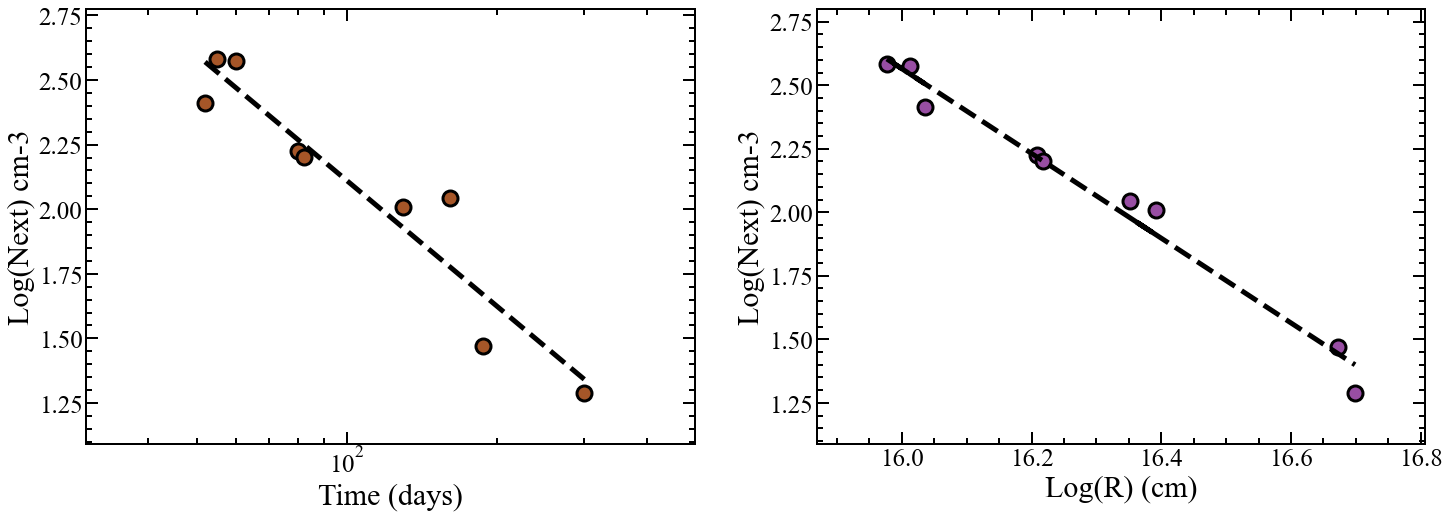

In [16]:
fig = plt.figure(figsize = (24,8))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
time = [52,55,60,80,82,130,161,188,300]

ax1.plot(time,np.log10(Next_list), 'o', markeredgecolor = 'black', markeredgewidth=3, markersize= 15, color = colors[4])
ax1.plot(time, m1*np.log10(np.array(time))+b1, 'k--', lw = 5)
ax2.plot(np.log10(R_list),np.log10(Next_list), 'o', markeredgecolor = 'black', markeredgewidth=3, markersize= 15, color = colors[5])
ax2.plot(np.log10(R_list), m2*np.log10(np.array(R_list))+b2, 'k--', lw = 5)

ax1.set_xscale('log')
ax1.set_ylabel('Log(Next) cm-3', fontsize = 30)
ax1.set_xlabel('Time (days)', fontsize = 30)
ax2.set_ylabel('Log(Next) cm-3', fontsize = 30)
ax2.set_xlabel('Log(R) (cm)', fontsize = 30)
ax1.set_xlim(3e1,5e2)
aesthetic(ax1)
aesthetic(ax2)
fig.savefig('final_plots/Next_overtime_and_R.jpg')

In [22]:
cnd = pd.read_csv('literature_TDEs/density_profile_litTDEs.csv', dtype = {'name':'string'})
TDEs = pd.read_csv('literature_TDEs/fluxes_litTDEs.csv', dtype = {'Name':'string'})
TDEs_uplim = pd.read_csv('literature_TDEs/TDE_upper_limits.csv', dtype = {'Name':'string'})

def dist(z):
    c = 299792.458 # km/s
    H0 = 70 #km/s/Mpc
    d = z*c/H0 # Mpc
    d = d*3.086e24 # converts to cm
    return d

def lum(F,z,nu):
    c = 299792.458 # km/s
    H0 = 70 #km/s/Mpc
    d = z*c/H0 # Mpc
    D = d*3.086e24 # converts to cm
    
    F_cgs = np.array(F) *1e-3*1e-23 # 10^-3 converts mJy -> Jy, 10^-23 coverts 1Jy to ergs s^-1 cm^2 Hz^-1
    
    nu_effective = np.array(nu)*1e9 # converts to Hz 
    
    L = F_cgs*4*np.pi*D**2*nu_effective
    return L

In [23]:
n = []
for i in TDEs.Name:
    if i not in n:
        n.append(i)

df1 = TDEs[TDEs['Name']==n[0]].reset_index()
df2 = TDEs[TDEs['Name']==n[1]].reset_index()
df3 = TDEs[TDEs['Name']==n[2]].reset_index()
df4 = TDEs[TDEs['Name']==n[3]].reset_index()
df5 = TDEs[TDEs['Name']==n[4]].reset_index()
df6 = TDEs[TDEs['Name']==n[5]].reset_index()
df7 = TDEs[TDEs['Name']==n[6]].reset_index()
df8 = TDEs[TDEs['Name']==n[7]].reset_index()
df9 = TDEs[TDEs['Name']==n[8]].reset_index()

In [24]:
df_yvette = pd.read_csv('AT2019dsg_data.csv', dtype = {'nu':float, 'F':float})

In [25]:
dfL = pd.DataFrame()
dfL['dt_years'] = np.array([55,82,161,300,561])/365
dfL['F_mJy'] = [0.09,0.26,0.56,0.79,0.13]
dfL['z'] = [0.051,0.051,0.051,0.051,0.051]
dfL['nu_GHz'] = [5.0,5.0,5.0,5.0,5.0] 

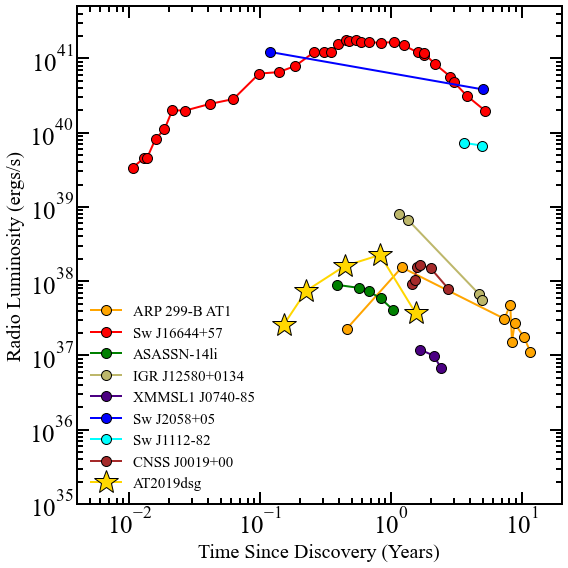

In [26]:
fig = plt.figure(figsize = (8,8))
ax = plt.subplot(111)

ax.plot(df1.dt_years,lum(df1.F_mJy, df1.z.to_list()[0],df1.nu_GHz),'o-', ms =10, mec='black',lw=2,c='orange', label = n[0])
ax.plot(df2.dt_years,lum(df2.F_mJy, df2.z.to_list()[0],df2.nu_GHz),'o-', ms =10, mec='black',lw=2,c='red', label = n[1])
ax.plot(df3.dt_years,lum(df3.F_mJy, df3.z.to_list()[0],df3.nu_GHz),'o-', ms =10, mec='black',lw=2,c='green', label = n[2])
ax.plot(df4.dt_years,lum(df4.F_mJy, df4.z.to_list()[0],df4.nu_GHz),'o-', ms =10, mec='black',lw=2,c='darkkhaki', label = n[3])
ax.plot(df5.dt_years,lum(df5.F_mJy, df5.z.to_list()[0],df5.nu_GHz),'o-', ms =10, mec='black',lw=2,c='indigo', label = n[4])
ax.plot(df7.dt_years,lum(df7.F_mJy, df7.z.to_list()[0],df7.nu_GHz),'o-', ms =10, mec='black',lw=2,c='blue', label = n[6])
ax.plot(df8.dt_years,lum(df8.F_mJy, df8.z.to_list()[0],df8.nu_GHz),'o-', ms =10, mec='black',lw=2,c='cyan', label = n[7])
ax.plot(df9.dt_years,lum(df9.F_mJy, df9.z.to_list()[0],df9.nu_GHz),'o-', ms =10, mec='black',lw=2,c='brown', label = n[8])

#ax.plot(df6.dt_years,lum(df6.F_mJy, df6.z.to_list()[0],df6.nu_GHz),'o-', ms =10, mec='black',lw=2,c='magenta', label = n[5])
ax.plot(dfL.dt_years,lum(dfL.F_mJy, dfL.z.to_list()[0],dfL.nu_GHz),'*-', ms =25, mec='black',lw=2,c='gold', label = n[5])

ax.set_xlim(4e-3,2e1)
ax.set_ylim(1e35,5e41)
ax.set_xlabel(r'Time Since Discovery (Years)', fontsize =20)
ax.set_ylabel(r'Radio Luminosity (ergs/s)', fontsize =20)
ax.set_yscale('log')
ax.set_xscale('log')
aesthetic(ax)
ax.legend(fontsize=15, framealpha = 0.0)
plt.tight_layout()
fig.savefig('final_plots/AT2019dsg_5GHz_lightcurve.jpg')

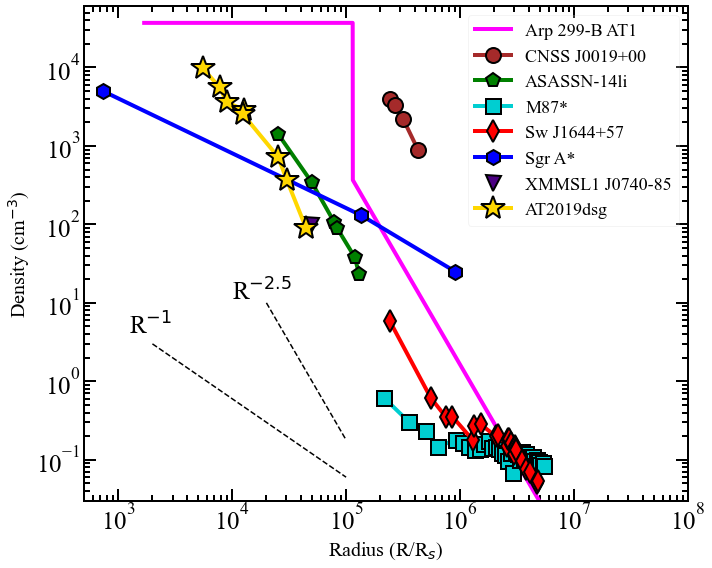

In [27]:
fig = plt.figure(figsize = (10,8))
ax = plt.subplot(111)
names = ['CNSS J0019+00','AT2019dsg','ASASSN-14li','Sw J1644+57','M87*','Sgr A*','Arp 299-B AT1','XMMSL1 J0740-85']
ax.plot(cnd[cnd['name']==names[6]]['R/Rs'],cnd[cnd['name']==names[6]]['n'],'-',mec='black',lw=4,c='magenta', label = names[6])
ax.plot(cnd[cnd['name']==names[0]]['R/Rs'],cnd[cnd['name']==names[0]]['n'],'o-',mec='black',lw=4,mew = 2,ms= 15,c='brown', label = names[0])
ax.plot(cnd[cnd['name']==names[2]]['R/Rs'],cnd[cnd['name']==names[2]]['n'],'p-',mec='black',lw=4,mew=2,ms= 15,c = 'green', label = names[2])
ax.plot(cnd[cnd['name']==names[4]]['R/Rs'],cnd[cnd['name']==names[4]]['n'],'s-',mec='black',lw=4,mew=2,ms= 15,c = 'darkturquoise', label = names[4])
ax.plot(cnd[cnd['name']==names[3]]['R/Rs'],cnd[cnd['name']==names[3]]['n'],'d-',mec='black',lw=4,mew=2,ms= 15,c = 'red', label = names[3])
ax.plot(cnd[cnd['name']==names[5]]['R/Rs'],cnd[cnd['name']==names[5]]['n'],'h-',mec='black',lw=4,mew=2,ms= 15,c = 'blue', label = names[5])
ax.plot(cnd[cnd['name']==names[7]]['R/Rs'],cnd[cnd['name']==names[7]]['n'],'v',mec='black',lw=4,mew=2,ms= 15,c = 'indigo', label = names[7])

ax.plot(cnd[cnd['name']==names[1]]['R/Rs'],cnd[cnd['name']==names[1]]['n'],'*-',mec='black',lw=4,mew=2,ms= 25,c = 'gold', label = names[1])


rmin=2e3
rmax=1e5
ax.plot([rmin,rmax],[3,3*(rmax/rmin)**(-1.)],'k--')
ax.text(1.25e3,4,r'R$^{-1}$',fontsize=25)
ax.plot([2e4,rmax],[10,10*(rmax/2e4)**(-2.5)],'k--')
ax.text(1e4,11,r'R$^{-2.5}$', fontsize=25)
ax.set_xlim(5e2,1e8)
ax.set_ylim([3e-2,6e4])
ax.set_xlabel(r'Radius (R/R$_s$)', fontsize =20)
ax.set_ylabel(r'Density (cm$^{-3}$)', fontsize =20)
ax.set_yscale('log')
ax.set_xscale('log')
aesthetic(ax)
#ax.vlines(x=1e6,ymin=1e2,ymax=1e5, color='k')    
#ax.hlines(y=1e2,xmin=1e6,xmax=1e8, color='k')    
ax.legend(loc = 1, fontsize=18, framealpha = 0.2)
plt.tight_layout()
fig.savefig('final_plots/AT2019dsg_density.jpg')